## Introducción
En las Lecciones 2 y 3, tratamos el pronóstico como un problema de regresión simple con todas nuestras características derivadas de una sola entrada, el índice de tiempo. Podríamos crear fácilmente pronósticos para cualquier momento en el futuro simplemente generando la tendencia deseada y las características estacionales.

Sin embargo, cuando agregamos características de retraso en la Lección 4, la naturaleza del problema cambió. Las características de retraso requieren que el valor objetivo retrasado se conozca en el momento de la previsión. Una característica de retraso 1 desplaza la serie de tiempo hacia adelante 1 paso, lo que significa que podría pronosticar 1 paso hacia el futuro pero no 2 pasos.

En la Lección 4, asumimos que siempre podíamos generar retrasos hasta el período que queríamos pronosticar (en otras palabras, cada predicción era solo para un paso adelante). Los pronósticos del mundo real generalmente exigen más que esto, por lo que en esta lección aprenderemos cómo hacer pronósticos para una variedad de situaciones.

## Definición de la tarea de previsión
Hay dos cosas que establecer antes de diseñar un modelo de pronóstico:

* qué información está disponible en el momento en que se hace un pronóstico (características), y,


* el período de tiempo durante el cual necesita valores pronosticados (objetivo).

El origen del pronóstico es el momento en el que está realizando un pronóstico. En la práctica, puede considerar que el origen del pronóstico es la última vez para la que tiene datos de entrenamiento para el tiempo que se está pronosticando. Todo hasta el origen se puede utilizar para crear funciones.

El horizonte de pronóstico es el tiempo para el cual está haciendo un pronóstico. A menudo describimos un pronóstico por el número de pasos de tiempo en su horizonte: un pronóstico de "1 paso" o un pronóstico de "5 pasos", por ejemplo. El horizonte de pronóstico describe el objetivo.

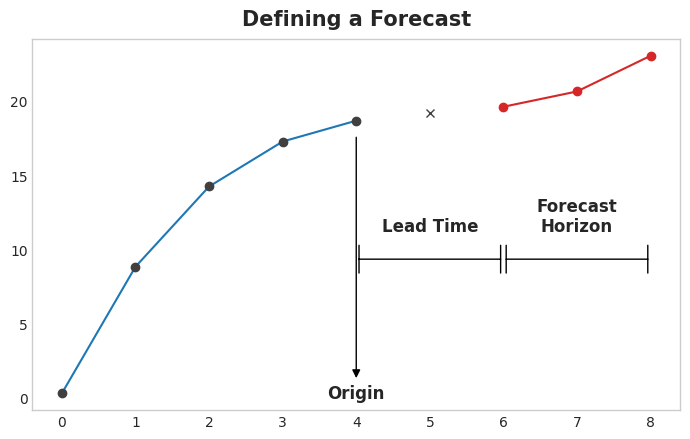

In [1]:
from IPython.display import Image
Image('../Kaglee/Data/Imagen_1_Lecc_6.png')

Un horizonte de pronóstico de tres pasos con un tiempo de anticipación de dos pasos, utilizando cuatro características de retraso. La figura representa lo que sería una sola fila de datos de entrenamiento, en otras palabras, datos para una sola predicción.

El tiempo entre el origen y el horizonte es el tiempo de anticipación (o, a veces, la latencia) del pronóstico. El tiempo de anticipación de un pronóstico se describe por la cantidad de pasos desde el origen hasta el horizonte: un pronóstico de "1 paso por delante" o "3 pasos por delante", por ejemplo. En la práctica, puede ser necesario que un pronóstico comience varios pasos antes del origen debido a demoras en la adquisición o procesamiento de datos.

## Preparación de datos para pronósticos
Para pronosticar series de tiempo con algoritmos de ML, necesitamos transformar la serie en un marco de datos que podamos usar con esos algoritmos. (A menos, por supuesto, que solo esté utilizando características deterministas como tendencia y estacionalidad).

Vimos la primera mitad de este proceso en la Lección 4 cuando creamos un conjunto de funciones a partir de retrasos. La segunda parte va preparando la diana. Cómo hacemos esto depende de la tarea de pronóstico.

Cada fila en un marco de datos representa un solo pronóstico. El índice de tiempo de la fila es la primera vez en el horizonte de pronóstico, pero organizamos los valores para todo el horizonte en la misma fila. Para los pronósticos de varios pasos, esto significa que necesitamos un modelo para producir múltiples resultados, uno para cada paso.

In [32]:
import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)
display(ts)
# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

print(data.head(30))
'''.style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})'''

Year
2010     0
2011     1
2012     2
2013     3
2014     4
2015     5
2016     6
2017     7
2018     8
2019     9
2020    10
2021    11
2022    12
2023    13
2024    14
2025    15
2026    16
2027    17
2028    18
2029    19
Freq: A-DEC, dtype: object

      Targets                   Features                                
     y_step_3 y_step_2 y_step_1  y_lag_2 y_lag_3 y_lag_4 y_lag_5 y_lag_6
Year                                                                    
2010        2        1        0      NaN     NaN     NaN     NaN     NaN
2011        3        2        1      NaN     NaN     NaN     NaN     NaN
2012        4        3        2        0     NaN     NaN     NaN     NaN
2013        5        4        3        1       0     NaN     NaN     NaN
2014        6        5        4        2       1       0     NaN     NaN
2015        7        6        5        3       2       1       0     NaN
2016        8        7        6        4       3       2       1       0
2017        9        8        7        5       4       3       2       1
2018       10        9        8        6       5       4       3       2
2019       11       10        9        7       6       5       4       3
2020       12       11       10        8       7   

".style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'})                    .set_properties(['Features'], **{'background-color': 'Lavender'})"

Lo anterior ilustra cómo se prepararía un conjunto de datos similar a la figura Definición de un pronóstico: una tarea de pronóstico de tres pasos con un tiempo de anticipación de dos pasos usando cinco funciones de retraso. La serie temporal original es y_step_1. Los valores faltantes que podríamos completar o eliminar

## Estrategias de pronóstico de varios pasos
Hay una serie de estrategias para producir los múltiples pasos objetivo requeridos para un pronóstico. Describiremos cuatro estrategias comunes, cada una con fortalezas y debilidades.

#### Modelo multisalida
Utilice un modelo que produzca múltiples resultados de forma natural. La regresión lineal y las redes neuronales pueden producir múltiples resultados. Esta estrategia es simple y eficiente, pero no es posible para todos los algoritmos que desee utilizar. XGBoost no puede hacer esto, por ejemplo.

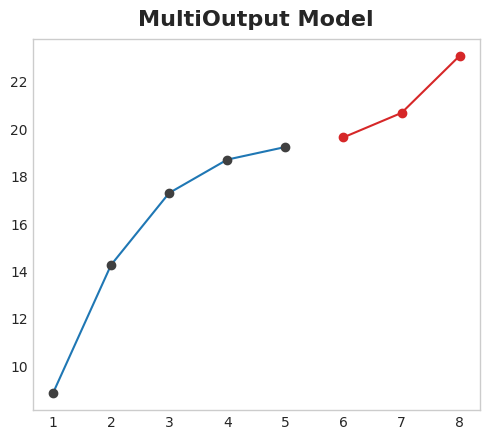

In [3]:
Image('../Kaglee/Data/Imagen_2_Lecc_6.png')

### Estrategia directa¶
Entrene un modelo separado para cada paso en el horizonte: un modelo pronostica 1 paso adelante, otro 2 pasos adelante, y así sucesivamente. Pronosticar 1 paso adelante es un problema diferente que 2 pasos adelante (y así sucesivamente), por lo que puede ser útil tener un modelo diferente para hacer pronósticos para cada paso. La desventaja es que entrenar muchos modelos puede ser computacionalmente costoso.

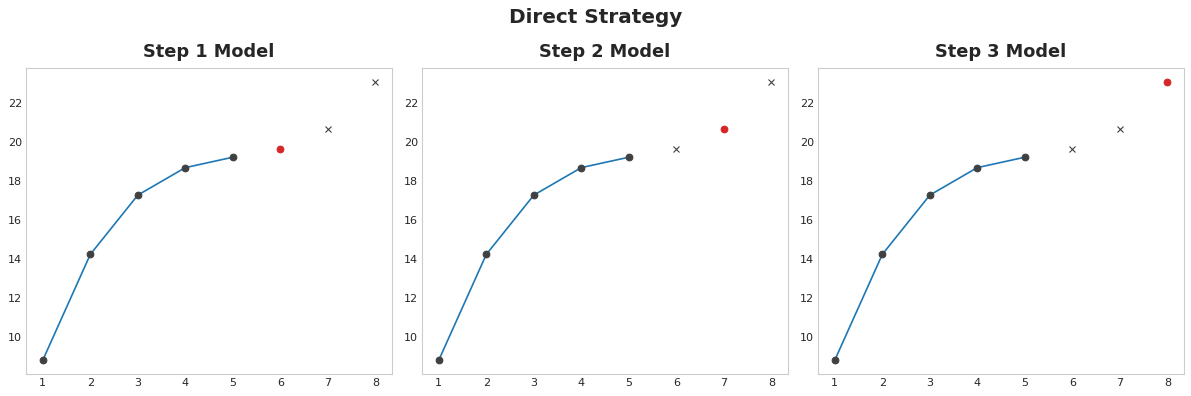

In [5]:
Image('../Kaglee/Data/Imagen_3_Lecc_6.png')

### Estrategia recursiva
Entrene un solo modelo de un solo paso y use sus pronósticos para actualizar las funciones de retraso para el siguiente paso. Con el método recursivo, introducimos el pronóstico de 1 paso de un modelo en ese mismo modelo para usarlo como característica de retraso para el próximo paso de pronóstico. Solo necesitamos entrenar un modelo, pero dado que los errores se propagarán paso a paso, los pronósticos pueden ser inexactos para horizontes largos

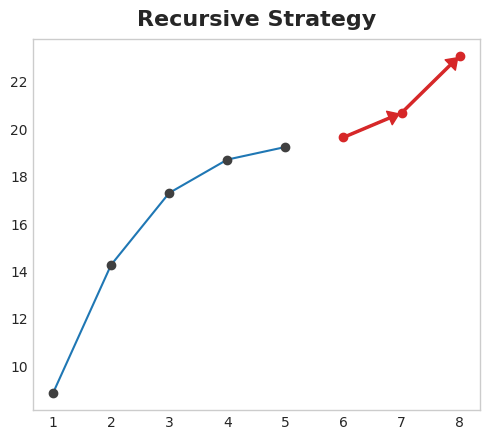

In [6]:
Image('../Kaglee/Data/Imagen_4_Lecc_6.png')

### Estrategia DirRec
Una combinación de estrategias directas y recursivas: entrene un modelo para cada paso y use pronósticos de pasos anteriores como nuevas características de retraso. Paso a paso, cada modelo obtiene una entrada de retraso adicional. Dado que cada modelo siempre tiene un conjunto actualizado de características de retraso, la estrategia DirRec puede capturar la dependencia serial mejor que Direct, pero también puede sufrir la propagación de errores como Recursive.

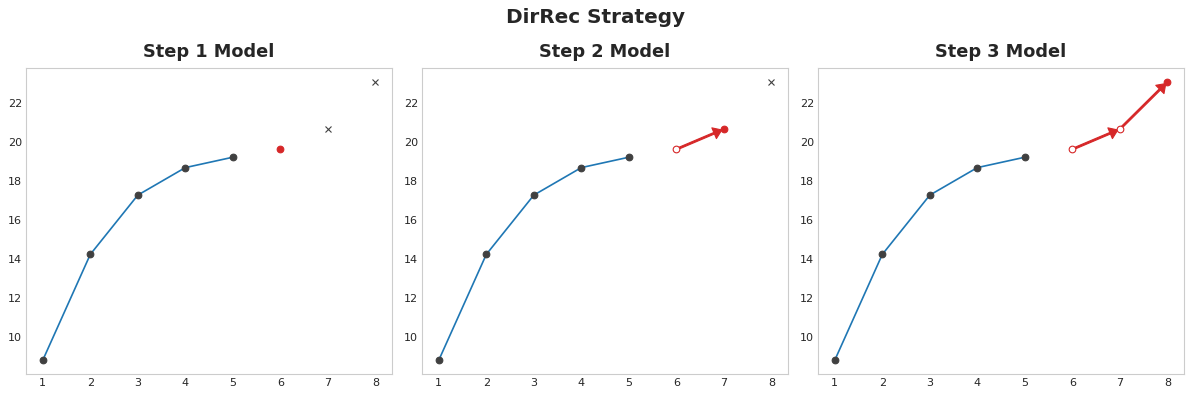

In [7]:
Image('../Kaglee/Data/Imagen_5_Lecc_6.png')

## Ejemplo - Tendencias de la gripe¶
En este ejemplo, aplicaremos las estrategias MultiOutput y Direct a los datos de Flu Trends de la Lección 4, esta vez haciendo pronósticos reales para varias semanas más allá del período de capacitación.

Definiremos nuestra tarea de pronóstico para que tenga un horizonte de 8 semanas con un tiempo de anticipación de 1 semana. En otras palabras, pronosticaremos ocho semanas de casos de gripe a partir de la semana siguiente.

La celda oculta configura el ejemplo y define una función auxiliar plot_multistep.

In [8]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


flu_trends = pd.read_csv('../Kaglee/Data/flu-trends.csv' )
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

Primero, prepararemos nuestra serie objetivo (visitas semanales al consultorio por gripe) para el pronóstico de varios pasos. Una vez hecho esto, el entrenamiento y la predicción serán muy sencillos.

In [39]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).fillna(0.0) #.dropna()
print(y)
# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

                       y_step_1  y_step_2  y_step_3  y_step_4  y_step_5  \
Week                                                                      
2009-06-29/2009-07-05       180     115.0     132.0     109.0     120.0   
2009-07-06/2009-07-12       115     132.0     109.0     120.0     115.0   
2009-07-13/2009-07-19       132     109.0     120.0     115.0     123.0   
2009-07-20/2009-07-26       109     120.0     115.0     123.0     205.0   
2009-07-27/2009-08-02       120     115.0     123.0     205.0     454.0   
...                         ...       ...       ...       ...       ...   
2016-05-30/2016-06-05        90      55.0      33.0      27.0      22.0   
2016-06-06/2016-06-12        55      33.0      27.0      22.0       0.0   
2016-06-13/2016-06-19        33      27.0      22.0       0.0       0.0   
2016-06-20/2016-06-26        27      22.0       0.0       0.0       0.0   
2016-06-27/2016-07-03        22       0.0       0.0       0.0       0.0   

                       y

In [35]:
y

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2009-06-29/2009-07-05,180,115.0,132.0,109.0,120.0,115.0,123.0,205.0
2009-07-06/2009-07-12,115,132.0,109.0,120.0,115.0,123.0,205.0,454.0
2009-07-13/2009-07-19,132,109.0,120.0,115.0,123.0,205.0,454.0,628.0
2009-07-20/2009-07-26,109,120.0,115.0,123.0,205.0,454.0,628.0,687.0
2009-07-27/2009-08-02,120,115.0,123.0,205.0,454.0,628.0,687.0,821.0
...,...,...,...,...,...,...,...,...
2016-04-11/2016-04-17,616,578.0,455.0,305.0,211.0,156.0,124.0,90.0
2016-04-18/2016-04-24,578,455.0,305.0,211.0,156.0,124.0,90.0,55.0
2016-04-25/2016-05-01,455,305.0,211.0,156.0,124.0,90.0,55.0,33.0


In [12]:
X

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0
...,...,...,...,...
2016-04-11/2016-04-17,712.0,955.0,1100.0,1326.0
2016-04-18/2016-04-24,616.0,712.0,955.0,1100.0
2016-04-25/2016-05-01,578.0,616.0,712.0,955.0


#### Modelo multisalida¶
Usaremos la regresión lineal como una estrategia MultiOutput. Una vez que tenemos nuestros datos preparados para múltiples salidas, el entrenamiento y la predicción son los mismos de siempre.

In [40]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Recuerde que un modelo de varios pasos producirá un pronóstico completo para cada instancia utilizada como entrada. Hay 269 semanas en el conjunto de entrenamiento y 90 semanas en el conjunto de prueba, y ahora tenemos un pronóstico de 8 pasos para cada una de estas semanas.

In [43]:
#Los antedecentes
y_test.tail(8)

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2016-05-09/2016-05-15,211,156.0,124.0,90.0,55.0,33.0,27.0,22.0
2016-05-16/2016-05-22,156,124.0,90.0,55.0,33.0,27.0,22.0,0.0
2016-05-23/2016-05-29,124,90.0,55.0,33.0,27.0,22.0,0.0,0.0
2016-05-30/2016-06-05,90,55.0,33.0,27.0,22.0,0.0,0.0,0.0
2016-06-06/2016-06-12,55,33.0,27.0,22.0,0.0,0.0,0.0,0.0
2016-06-13/2016-06-19,33,27.0,22.0,0.0,0.0,0.0,0.0,0.0
2016-06-20/2016-06-26,27,22.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-27/2016-07-03,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
#Las predicciones estan aqui.
y_pred.tail(8)

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2016-05-09/2016-05-15,221.712364,169.123749,136.199308,127.910741,145.401994,174.693347,195.595111,213.636630
2016-05-16/2016-05-22,155.174710,121.571756,114.727843,130.853824,159.121525,181.966547,201.077522,220.325436
2016-05-23/2016-05-29,120.761908,111.819993,123.157430,153.979336,180.473675,201.520086,223.078974,242.099889
2016-05-30/2016-06-05,111.428979,118.610754,138.900909,171.201196,200.289324,225.858402,249.877428,270.637224
2016-06-06/2016-06-12,83.967495,98.543521,121.992918,154.886834,187.457863,220.953035,250.440637,275.017739
2016-06-13/2016-06-19,54.611736,72.682926,99.368797,133.956556,172.496023,212.123852,245.386284,273.693510
2016-06-20/2016-06-26,41.474884,64.998854,97.443143,136.073078,177.538746,217.156270,250.506940,279.525976
2016-06-27/2016-07-03,44.488125,74.750172,112.151647,153.508609,194.184480,231.644127,263.846249,291.785328


In [25]:
flu_trends.FluVisits.tail(10)

Week
2016-04-25/2016-05-01    455
2016-05-02/2016-05-08    305
2016-05-09/2016-05-15    211
2016-05-16/2016-05-22    156
2016-05-23/2016-05-29    124
2016-05-30/2016-06-05     90
2016-06-06/2016-06-12     55
2016-06-13/2016-06-19     33
2016-06-20/2016-06-26     27
2016-06-27/2016-07-03     22
Freq: W-SUN, Name: FluVisits, dtype: int64

Train RMSE: 385.93
Test RMSE: 577.28


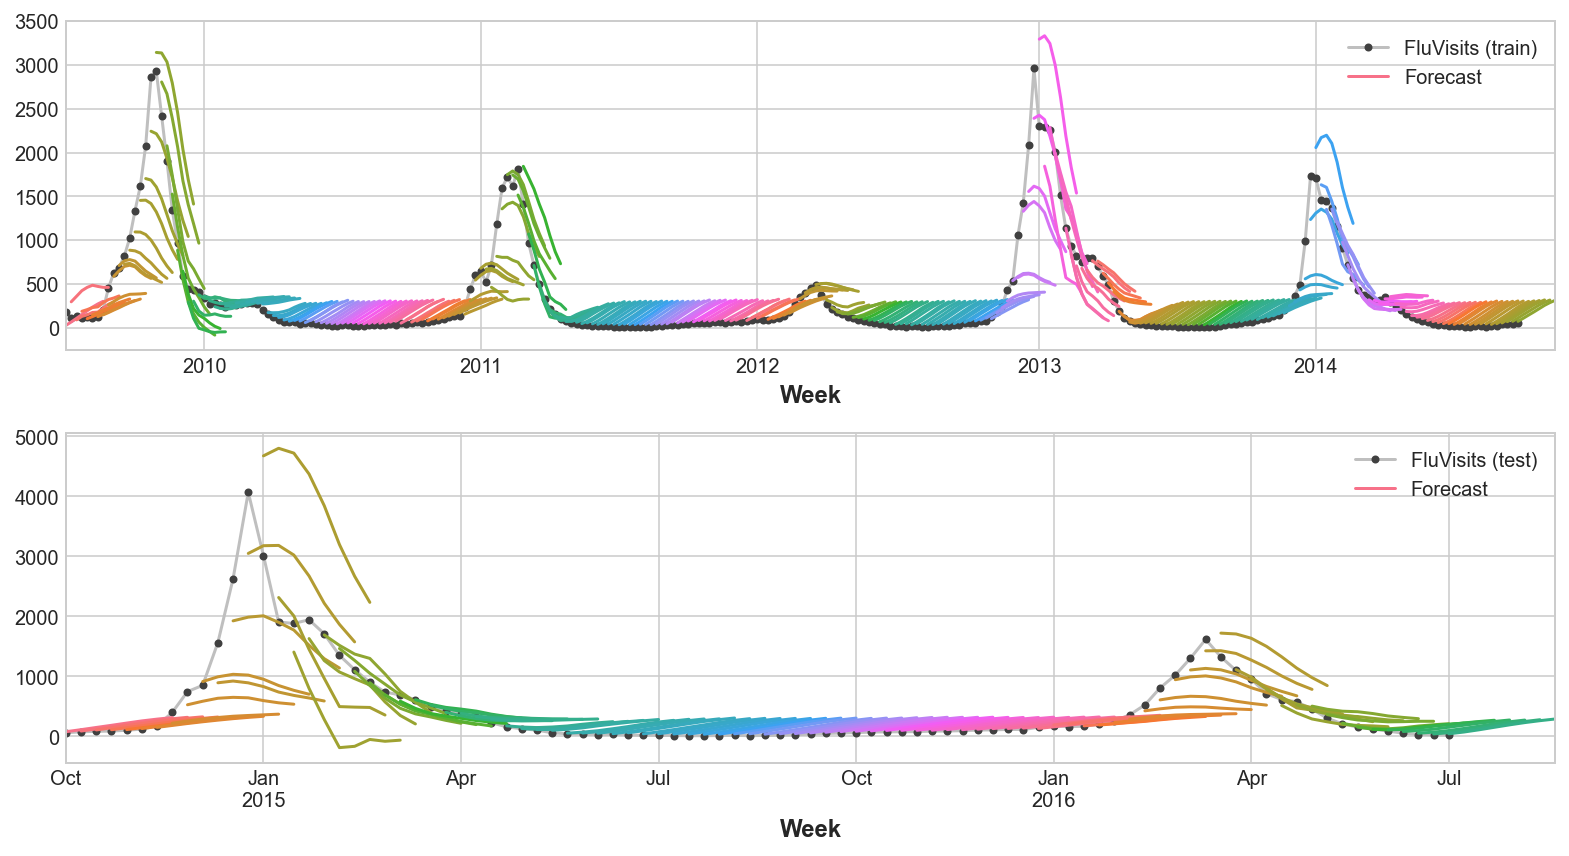

In [41]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### Estrategia directa
XGBoost no puede producir múltiples salidas para tareas de regresión. Pero al aplicar la estrategia de reducción directa, todavía podemos usarla para producir pronósticos de varios pasos. Esto es tan fácil como envolverlo con MultiOutputRegressor de scikit-learn.

In [44]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

XGBoost aquí está claramente sobreajustado en el conjunto de entrenamiento. Pero en el conjunto de prueba parece que pudo capturar algunas de las dinámicas de la temporada de gripe mejor que el modelo de regresión lineal. Probablemente funcionaría aún mejor con algunos ajustes de hiperparámetros.

Train RMSE: 1.22
Test RMSE: 519.87


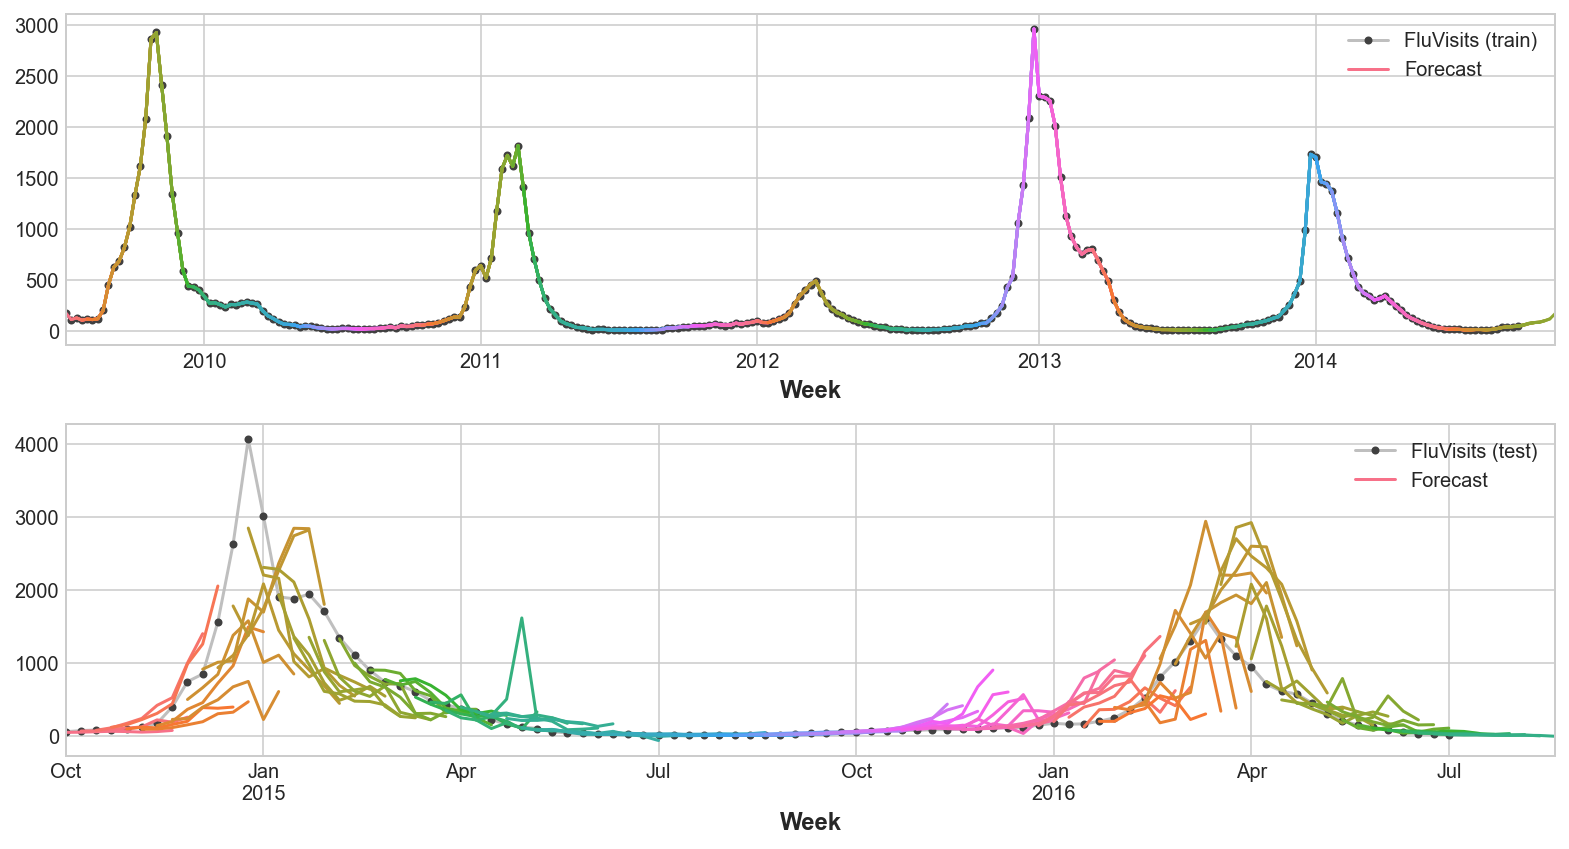

In [45]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

Para usar la estrategia DirRec, solo necesita reemplazar MultiOutputRegressor con otro contenedor de scikit-learn, RegressorChain. La estrategia recursiva que tendríamos que codificar nosotros mismos.